<h1>Feedback Prize - English Language Learning</h1>

<h2>Reading data</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
import transformers

from tensorflow import keras
from sklearn.model_selection import train_test_split

train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [2]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


<h2>Wordcloud Visualization</h2>

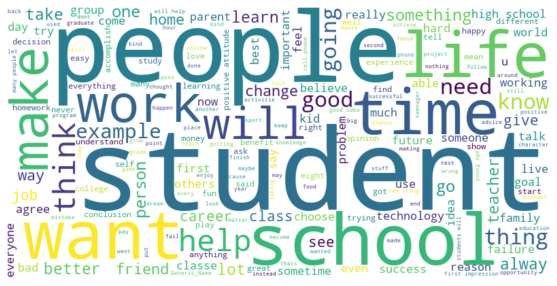

In [4]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>Preprocessing with BERT</h2>

In [5]:
MAX_LENGTH = 512
OFFLINE_TOKENIZER = "../input/bert-cased-base"
tokenizer = transformers.BertTokenizer.from_pretrained(OFFLINE_TOKENIZER, do_lower_case=True)


In [6]:
def tokenize_sentences(texts):
    encoded = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            return_attention_mask=True,
            return_token_type_ids=None,
            truncation=True,
            return_tensors="tf",
            padding='max_length')
    input_ids = pd.DataFrame(encoded['input_ids'].numpy(), columns=["input_"+str(i) for i in range(MAX_LENGTH)])
    #attention_mask = pd.DataFrame(encoded['attention_mask'].numpy(), columns=["mask_"+str(i) for i in range(MAX_LENGTH)])
    #tokenized = pd.concat([input_ids, attention_mask], axis=1)
    return input_ids



tokenized_train = tokenize_sentences(train['full_text'])
tokenized_test = tokenize_sentences(test['full_text'])

2022-10-26 14:02:25.835767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:02:25.836961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:02:26.031360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:02:26.032279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:02:26.033085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

<h2>Model building</h2>

In [7]:
targets = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

X = tokenized_train
y = train[targets]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3128, 512)
(3128, 6)
(783, 512)
(783, 6)


In [32]:
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
#lambdas = [0.0]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    
    inputs = tf.keras.layers.Input(shape=(512,))
    emb = tf.keras.layers.Embedding(input_dim=512, output_dim=100)(inputs)
    conv = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))(emb)
    bilstm = tf.keras.layers.Bidirectional(keras.layers.LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(lambda_)))(emb)
    #attention1 = tf.keras.layers.Attention()([bilstm, bilstm])
    #attention2 = tf.keras.layers.Attention()([attention1, attention1])
    output = keras.layers.Dense(6)(bilstm)
    
    models[i] = tf.keras.Model([inputs], [output])
    
    models[i].compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    models[i].fit(
        X_train, y_train,
        epochs=100,
        verbose=1
    )
    print(f"finished lambda: {lambda_}, score: {models[i].evaluate(X_train, y_train)}")

Epoch 1/100
98/98 [==============================] - 8s 55ms/step - loss: 1.1950
Epoch 2/100
98/98 [==============================] - 6s 56ms/step - loss: 0.4194
Epoch 3/100
98/98 [==============================] - 5s 52ms/step - loss: 0.4201
Epoch 4/100
98/98 [==============================] - 5s 53ms/step - loss: 0.4122
Epoch 5/100
98/98 [==============================] - 6s 56ms/step - loss: 0.4126
Epoch 6/100
98/98 [==============================] - 5s 55ms/step - loss: 0.4112
Epoch 7/100
98/98 [==============================] - 5s 53ms/step - loss: 0.4066
Epoch 8/100
98/98 [==============================] - 5s 55ms/step - loss: 0.4152
Epoch 9/100
98/98 [==============================] - 5s 50ms/step - loss: 0.4101
Epoch 10/100
98/98 [==============================] - 5s 54ms/step - loss: 0.4042
Epoch 11/100
98/98 [==============================] - 5s 52ms/step - loss: 0.4056
Epoch 12/100
98/98 [==============================] - 5s 53ms/step - loss: 0.4001
Epoch 13/100
98/98 [=====

In [34]:
best_score = 100000000
best_model = 0
for m in models:
    score = m.evaluate(X_val, y_val)
    print(score)
    if score < best_score:
        best_score = score
        best_model = m

25/25 [==============================] - 1s 24ms/step - loss: 0.3764
0.3764260709285736
25/25 [==============================] - 1s 34ms/step - loss: 0.3857
0.38569432497024536
25/25 [==============================] - 1s 22ms/step - loss: 0.4278
0.4277969002723694
25/25 [==============================] - 1s 21ms/step - loss: 0.4435
0.4434620440006256
25/25 [==============================] - 1s 21ms/step - loss: 0.4555
0.45552894473075867
25/25 [==============================] - 1s 20ms/step - loss: 0.4425
0.4424976706504822
25/25 [==============================] - 1s 20ms/step - loss: 0.4618
0.4618145227432251


In [35]:
print("prev_score: ", best_score)
best_model.fit(X_val, y_val, epochs=100, verbose=0)
score = best_model.evaluate(X_val, y_val)
print("Eval Score: ", score)


prev_score:  0.3764260709285736
25/25 [==============================] - 1s 24ms/step - loss: 0.0479
Eval Score:  0.04786694794893265


In [36]:
score = best_model.evaluate(X_train, y_train)
print("Train Score: ", score)

98/98 [==============================] - 2s 22ms/step - loss: 0.5206
Train Score:  0.5206136703491211


In [37]:
X_sub = tokenized_test

res = best_model.predict(X_sub)
res

array([[2.8841643, 3.0807362, 3.5926492, 3.3417253, 2.7357948, 3.3156455],
       [3.4049644, 2.9040067, 3.1440942, 3.3401995, 2.9387858, 3.1814933],
       [2.940161 , 3.2295938, 3.1241508, 2.8660638, 2.766556 , 3.2658057]],
      dtype=float32)

In [38]:
def myround(x, prec=2, base=.5):
  return round(base * round(float(x)/base),prec)

rounded_res = [[] for i in range(test.shape[0])]
for i in range(len(res)):
    for j in range(len(res[i])):
        rounded_res[i].append(myround(x = res[i][j]))
rounded_res

[[3.0, 3.0, 3.5, 3.5, 2.5, 3.5],
 [3.5, 3.0, 3.0, 3.5, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.5]]

In [39]:
submission = pd.concat([test['text_id'], pd.DataFrame(rounded_res, columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])], axis=1)
submission.to_csv("submission.csv", index = False)
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.5,3.5,2.5,3.5
1,000BAD50D026,3.5,3.0,3.0,3.5,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.5
